In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ! pip install neuralprophet[live]
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import seaborn as sns
import pickle
import holidays
import itertools
from neuralprophet import NeuralProphet, set_random_seed, save, load



#Load Data

In [4]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
FORECAST_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Forecast"
MPLOT_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Plot"

In [5]:
NYC = pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv", index_col = 0)
NYC = NYC.rename({'Time Stamp': 'ds', 'N.Y.C.': 'y'}, axis = 1)
NYC['ds'] = pd.to_datetime(NYC.ds)
NYC = NYC.drop(labels = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'LONGIL', 'MHK VL', 
                   'HUD VL', 'MILLWD', 'NORTH', 'WEST', 'NYCA', 
                   'month', 'day', 'hour', 'minute', 'PeriodEnd', 'PeriodStart',
                   'Period', 'datetime','dow_x','dow_y'], axis = 1)



In [6]:
NYC

ds          y  year  AirTemp  Azimuth  CloudOpacity  \
0      2017-01-01 00:00:00  5116.9000  2017      6.8      1.0          76.4   
1      2017-01-01 00:05:00  5102.1000  2017      6.8     -3.0          76.4   
2      2017-01-01 00:10:00  5074.9000  2017      6.8     -7.0          76.4   
3      2017-01-01 00:15:00  5089.6000  2017      6.8    -11.0          76.4   
4      2017-01-01 00:20:00  5061.3000  2017      6.9    -14.0          76.4   
...                    ...        ...   ...      ...      ...           ...   
631003 2022-12-31 23:35:00  4749.6870  2022      8.6     19.0          89.7   
631004 2022-12-31 23:40:00  4738.3370  2022      8.6     16.0          88.2   
631005 2022-12-31 23:45:00  4731.2676  2022      8.5     12.0          86.5   
631006 2022-12-31 23:50:00  4721.4570  2022      8.5      8.0          85.0   
631007 2022-12-31 23:55:00  4716.7217  2022      8.5      4.0          83.4   

        DewpointTemp  Dhi  Dni  Ebh  ...  PrecipitableWater  RelativeHumidity  \
0               -4.8  0.0  0.0  0.0  ...               14.5              43.5   
1               -4.8  0.0  0.0  0.0  ...               14.5              43.5   
2               -4.7  0.0  0.0  0.0  ...               14.5              43.5   
3               -4.7  0.0  0.0  0.0  ...               14.5              43.5   
4               -4.7  0.0  0.0  0.0  ...               14.5              43.5   
...              ...  ...  ...  ...  ...                ...               ...   
631003           8.5  0.0  0.0  0.0  ...               27.5              99.2   
631004           8.5  0.0  0.0  0.0  ...               27.2              99.2   
631005           8.4  0.0  0.0  0.0  ...               26.9              99.2   
631006           8.4  0.0  0.0  0.0  ...               26.6              99.2   
631007           8.4  0.0  0.0  0.0  ...               26.3              99.2   

        SnowWater  SurfacePressure  WindDirection10m  WindSpeed10m  Zenith  \
0             0.0           1011.9             226.0           7.0   162.0   
1             0.0           1011.9             227.0           7.0   162.0   
2             0.0           1011.9             227.0           7.0   162.0   
3             0.0           1011.9             228.0           7.0   162.0   
4             0.0           1011.9             228.0           7.0   162.0   
...           ...              ...               ...           ...     ...   
631003        0.0           1014.8             252.0           2.5   162.0   
631004        0.0           1014.7             251.0           2.4   162.0   
631005        0.0           1014.6             250.0           2.4   162.0   
631006        0.0           1014.5             249.0           2.3   162.0   
631007        0.0           1014.4             247.0           2.2   162.0   

        AlbedoDaily  HourlyDryBulbTemperature  HourlyRelativeHumidity  
0              0.12                 44.000000                    51.0  
1              0.13                 44.000000                    51.0  
2              0.13                 44.000000                    51.0  
3              0.13                 44.000000                    51.0  
4              0.13                 44.000000                    51.0  
...             ...                       ...                     ...  
631003         0.10                 48.451613                   100.0  
631004         0.10                 48.290323                   100.0  
631005         0.10                 48.129032                   100.0  
631006         0.10                 48.500000                   100.0  
631007         0.10                 49.000000                   100.0  

[631008 rows x 23 columns]

In [7]:
train =  NYC[NYC.ds < '2022-1-1']
val = NYC.loc[len(train)-70:, ] #include last 18 point from 2021 so can make prediction for early 2022
val

ds          y  year  AirTemp  Azimuth  CloudOpacity  \
525818 2021-12-31 18:10:00  5553.6167  2021     10.9    107.0          91.8   
525819 2021-12-31 18:15:00  5540.8650  2021     10.8    106.0          88.1   
525820 2021-12-31 18:20:00  5529.9307  2021     10.7    105.0          77.4   
525821 2021-12-31 18:25:00  5561.7900  2021     10.6    104.0          67.9   
525822 2021-12-31 18:30:00  5528.6626  2021     10.5    104.0          79.9   
...                    ...        ...   ...      ...      ...           ...   
631003 2022-12-31 23:35:00  4749.6870  2022      8.6     19.0          89.7   
631004 2022-12-31 23:40:00  4738.3370  2022      8.6     16.0          88.2   
631005 2022-12-31 23:45:00  4731.2676  2022      8.5     12.0          86.5   
631006 2022-12-31 23:50:00  4721.4570  2022      8.5      8.0          85.0   
631007 2022-12-31 23:55:00  4716.7217  2022      8.5      4.0          83.4   

        DewpointTemp  Dhi  Dni  Ebh  ...  PrecipitableWater  RelativeHumidity  \
525818           7.7  0.0  0.0  0.0  ...               18.6              80.6   
525819           7.7  0.0  0.0  0.0  ...               18.7              81.0   
525820           7.6  0.0  0.0  0.0  ...               18.7              81.4   
525821           7.6  0.0  0.0  0.0  ...               18.7              81.8   
525822           7.6  0.0  0.0  0.0  ...               18.7              82.1   
...              ...  ...  ...  ...  ...                ...               ...   
631003           8.5  0.0  0.0  0.0  ...               27.5              99.2   
631004           8.5  0.0  0.0  0.0  ...               27.2              99.2   
631005           8.4  0.0  0.0  0.0  ...               26.9              99.2   
631006           8.4  0.0  0.0  0.0  ...               26.6              99.2   
631007           8.4  0.0  0.0  0.0  ...               26.3              99.2   

        SnowWater  SurfacePressure  WindDirection10m  WindSpeed10m  Zenith  \
525818        0.0           1021.6             253.0           1.6   107.0   
525819        0.0           1021.7             253.0           1.6   108.0   
525820        0.0           1021.8             253.0           1.6   108.0   
525821        0.0           1021.8             253.0           1.6   109.0   
525822        0.0           1021.9             253.0           1.5   110.0   
...           ...              ...               ...           ...     ...   
631003        0.0           1014.8             252.0           2.5   162.0   
631004        0.0           1014.7             251.0           2.4   162.0   
631005        0.0           1014.6             250.0           2.4   162.0   
631006        0.0           1014.5             249.0           2.3   162.0   
631007        0.0           1014.4             247.0           2.2   162.0   

        AlbedoDaily  HourlyDryBulbTemperature  HourlyRelativeHumidity  
525818         0.11                 48.000000               98.000000  
525819         0.11                 48.000000               98.526316  
525820         0.11                 48.000000               99.052632  
525821         0.11                 48.000000               99.578947  
525822         0.11                 48.045455               99.863636  
...             ...                       ...                     ...  
631003         0.10                 48.451613              100.000000  
631004         0.10                 48.290323              100.000000  
631005         0.10                 48.129032              100.000000  
631006         0.10                 48.500000              100.000000  
631007         0.10                 49.000000              100.000000  

[105190 rows x 23 columns]

In [8]:
print(train.shape) # quick check to see if the size of data is expected. 
print(val.shape)

(525888, 23)
(105190, 23)


In [9]:
sum(train.year<2021)

420768

In [10]:
def get_cols(cols = None, train = train, val= val):
  col_requested = ['ds', 'y']
  if cols: 
    col_requested += cols
  return train[col_requested] , val[col_requested]



In [11]:
def RRMSE(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss
trainer_config = {"accelerator":"gpu"}

In [12]:
t = int(365*24*(60/5))-18
actual_load=NYC.iloc[-t:]['y']
trainer_config = {"accelerator":"gpu"}


# Grid Search



In [13]:
import logging

logger = logging.getLogger()
logging.basicConfig(level=logging.ERROR)

In [14]:
holiday_dict = {} 
for year in range(2017,2024):
  holiday_dict.update(holidays.US(state='NY', years=year))


df_holiday = pd.DataFrame.from_dict({datetime.combine(dt, datetime.min.time()) + timedelta(hours=5*i/60): 'holiday'
      for dt, hol in holiday_dict.items() for i in range(int(60/5*24)) }, orient = 'index')\
      .reset_index()\
      .rename({'index':'ds', 0:'event'}, axis = 1)

In [27]:
feature_columns = ['HourlyDryBulbTemperature', 'Dni']
REG_PARAM = 0.8

grid = {'seasonality_reg':[0.1,0.5, 1, 5],
 'daily_seasonality':[4,6,10,12]}

keys, values = zip(*grid.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

config = {'n_lags':18,
          'n_forecasts': 18,
          'yearly_seasonality':True, 
          'weekly_seasonality':True, 
          'daily_seasonality':True,
          'seasonality_mode':"multiplicative",
          'newer_samples_weight' :2.5,
          'num_hidden_layers' : 1,
          'seasonality_reg' : 0.5,
          'epochs' : 25, 
          'trend_reg' : 1,
          'trainer_config': trainer_config}
results = {}
for exp in experiments: 
  config.update(exp)

  m_h_w_f_m = NeuralProphet(**config)

  m_h_w_f_m = m_h_w_f_m.add_events(['holiday'], mode='multiplicative', regularization = REG_PARAM)
  m_h_w_f_m = m_h_w_f_m.add_lagged_regressor(names = feature_columns, regularization = REG_PARAM) 
  for col in feature_columns:
    m_h_w_f_m = m_h_w_f_m.add_future_regressor(f'{col}_f', mode='multiplicative', regularization = REG_PARAM) 
  m_h_w_f_m = m_h_w_f_m.highlight_nth_step_ahead_of_each_forecast(18)
  name = f"sea_{m_h_w_f_m.config['daily_seasonality']}_reg_{m_h_w_f_m.config['seasonality_reg']}"

  set_random_seed(2023)
  train_w, val_w = get_cols(feature_columns)
  for col in feature_columns:
    train_w[f'{col}_f']= train_w[col]
    val_w[f'{col}_f']= val_w[col]

  train_w = m_h_w_f_m.create_df_with_events(train_w, df_holiday)
  val_w = m_h_w_f_m.create_df_with_events(val_w, df_holiday)

  m_h_w_f_m_metric = m_h_w_f_m.fit(train_w,
                            validation_df = val_w,
                            freq='5min')

  forecast_h_w_f_m_raw = m_h_w_f_m.predict(val_w, raw = True)
  forecast_h_w_f_m = m_h_w_f_m.predict(val_w)

  m_h_w_f_m = m_h_w_f_m.highlight_nth_step_ahead_of_each_forecast()
  param = m_h_w_f_m.plot_parameters(plotting_backend = 'default')
  param.savefig(f'{MPLOT_DIR}/NP_{name}.png') 

  forecast_h_w_f_m['error17'] = forecast_h_w_f_m['yhat17'] - forecast_h_w_f_m['y']
  forecast_h_w_f_m_raw.to_csv(f'{FORECAST_DIR}/neuralprophet_{name}_raw.csv')
  forecast_h_w_f_m.to_csv(f'{FORECAST_DIR}/neuralprophet_{name}_f.csv')
  save(m_h_w_f_m, f"{MODEL_DIR}/neuralphrophet_{name}_f.np")
  results[name] = RRMSE(np.array(forecast_h_w_f_m[34:-18]['y']), np.array(forecast_h_w_f_m[34:-18]['yhat17']))

results

Output hidden; open in https://colab.research.google.com to view.

<Axes: xlabel='ds'>

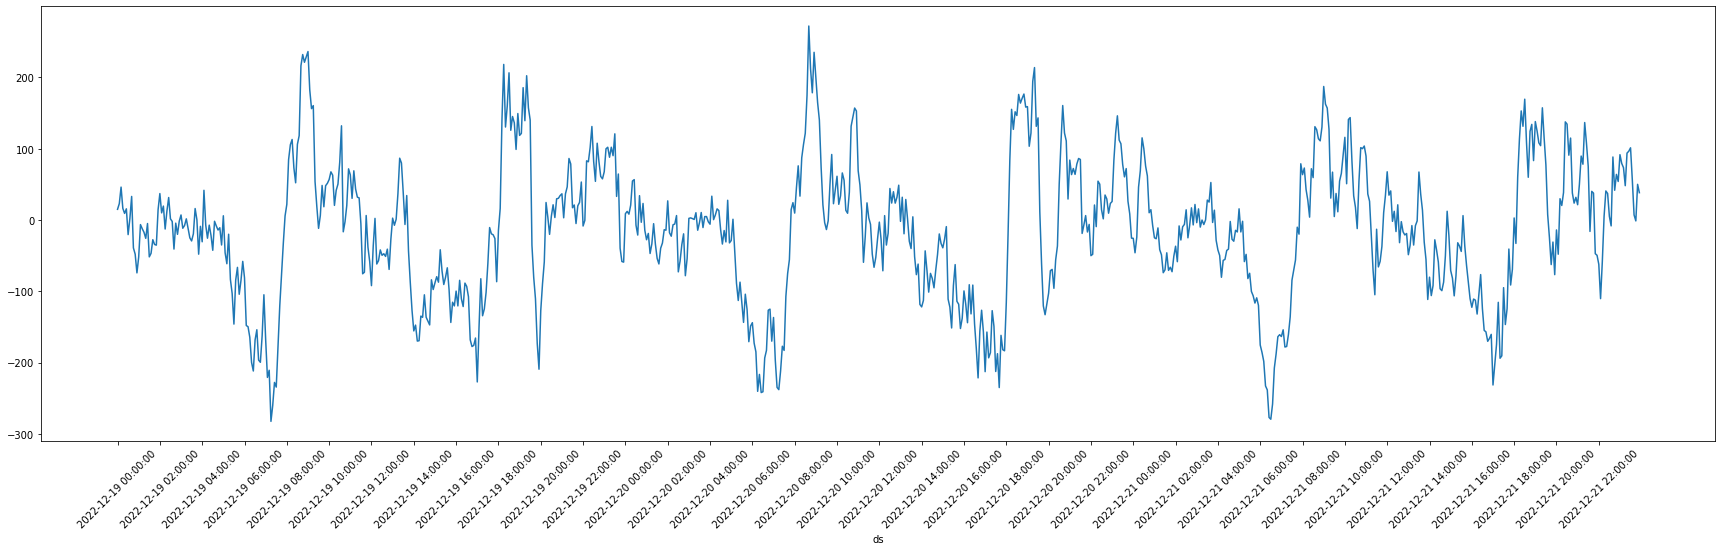

In [32]:
forecast1 = forecast.set_index('ds')
forecast1.iloc[-24*12*13:-24*12*10,]['error'].plot(figsize=(30,8), xticks=list(range(0,864,)), rot = 45)



#Deeper Net

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)
INFO:NP.forecaster:n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)
WARNING - (py.warnings._showwarnmsg) - <ipython-input-50-1c007376ec1c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_w[f'{col}_f']= train_w[col]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Finding best initial lr:   0%|          | 0/293 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.predict) - Raw forecasts are incompatible with plotting utilities
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 4109it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 4109it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


0.026457047884975368


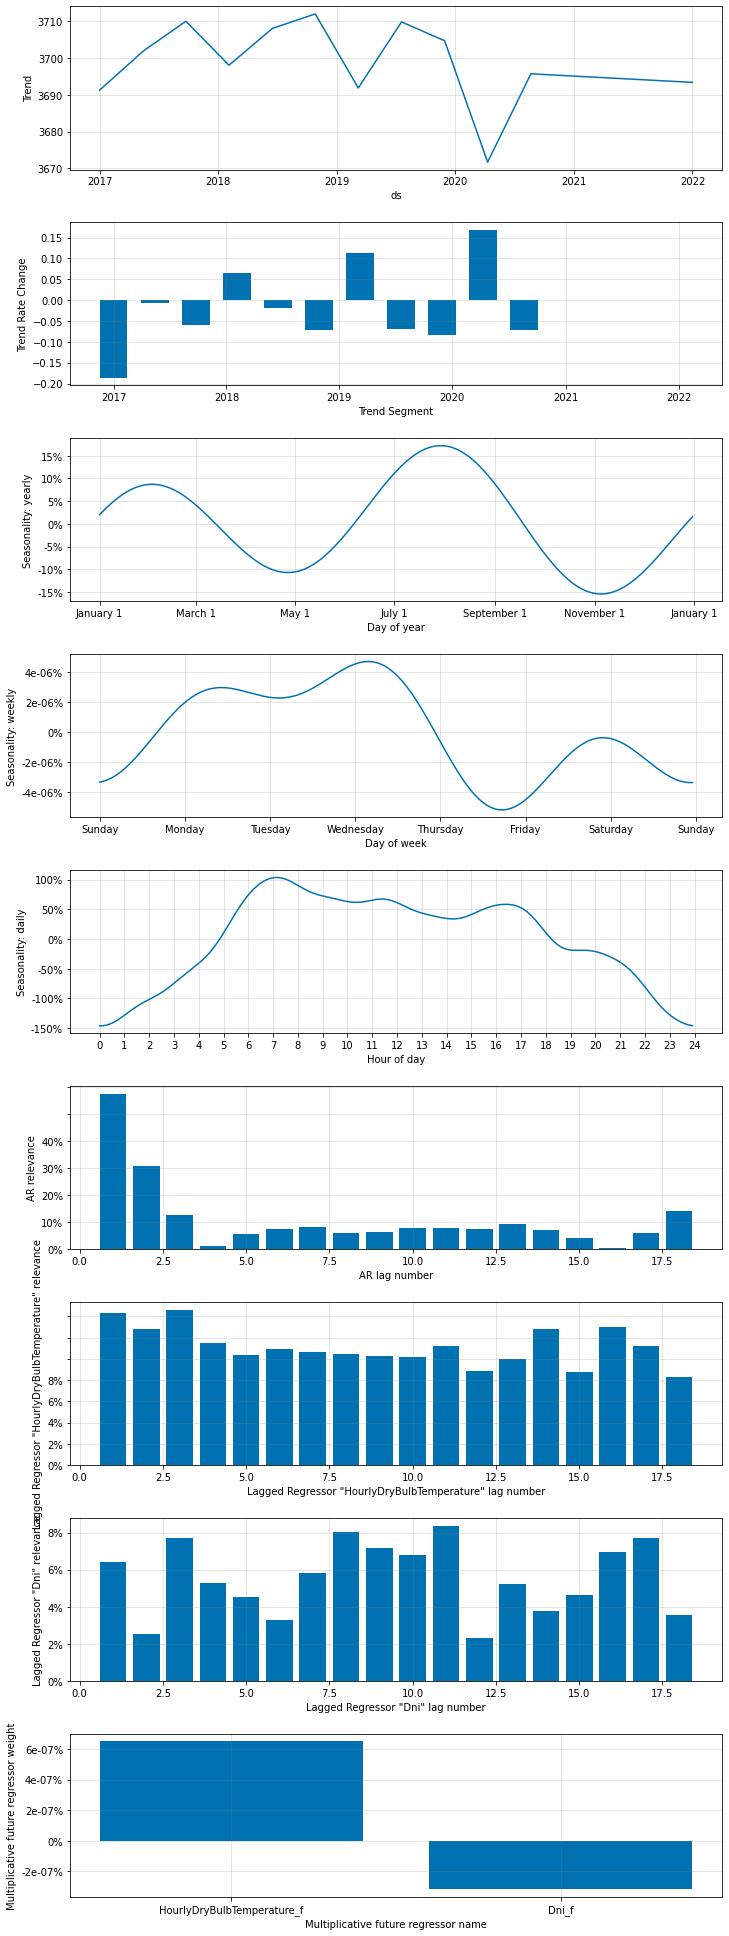

In [50]:
feature_columns = ['HourlyDryBulbTemperature', 'Dni']

REG_PARAM=0.1
config = {'n_lags':18,
          'n_forecasts': 18,
          'yearly_seasonality':True, 
          'weekly_seasonality':True, 
          'daily_seasonality':12,
          'seasonality_mode':"multiplicative",
          'newer_samples_weight' :2.5,
          'num_hidden_layers' : 5,
          'seasonality_reg' : 0.1,
          'epochs' : 35, 
          'trainer_config': trainer_config}


m_h_w_f_m = NeuralProphet(**config)

m_h_w_f_m = m_h_w_f_m.add_events(['holiday'], mode='multiplicative', regularization = REG_PARAM)
m_h_w_f_m = m_h_w_f_m.add_lagged_regressor(names = feature_columns, regularization = REG_PARAM) 
for col in feature_columns:
  m_h_w_f_m = m_h_w_f_m.add_future_regressor(f'{col}_f', mode='multiplicative', regularization = REG_PARAM) 
m_h_w_f_m = m_h_w_f_m.highlight_nth_step_ahead_of_each_forecast(18)
name = f"sea_{m_h_w_f_m.config['daily_seasonality']}_reg_{m_h_w_f_m.config['seasonality_reg']}_deep"

set_random_seed(2023)
train_w, val_w = get_cols(feature_columns)
for col in feature_columns:
  train_w[f'{col}_f']= train_w[col]
  val_w[f'{col}_f']= val_w[col]

train_w = m_h_w_f_m.create_df_with_events(train_w, df_holiday)
val_w = m_h_w_f_m.create_df_with_events(val_w, df_holiday)

m_h_w_f_m_metric = m_h_w_f_m.fit(train_w,
                          validation_df = val_w,
                          freq='5min')

forecast_h_w_f_m_raw = m_h_w_f_m.predict(val_w, raw = True)
forecast_h_w_f_m = m_h_w_f_m.predict(val_w)

m_h_w_f_m = m_h_w_f_m.highlight_nth_step_ahead_of_each_forecast()
param = m_h_w_f_m.plot_parameters(plotting_backend = 'default')
param.savefig(f'{MPLOT_DIR}/NP_{name}.png') 

forecast_h_w_f_m['error17'] = forecast_h_w_f_m['yhat17'] - forecast_h_w_f_m['y']
forecast_h_w_f_m_raw.to_csv(f'{FORECAST_DIR}/neuralprophet_{name}_raw.csv')
forecast_h_w_f_m.to_csv(f'{FORECAST_DIR}/neuralprophet_{name}_f.csv')
save(m_h_w_f_m, f"{MODEL_DIR}/neuralphrophet_{name}_f.np")
print(RRMSE(np.array(forecast_h_w_f_m[34:-18]['y']), np.array(forecast_h_w_f_m[34:-18]['yhat17'])))

<Axes: xlabel='ds'>

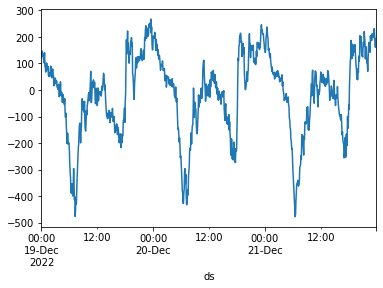

In [54]:
forecast1.iloc[-24*12*13:-24*12*10,]['error17'].plot(figsize=(30,8), xticks=list(range(0,864,)), rot = 45)

# Add estimation indicator 


INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)
INFO:NP.forecaster:n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)
WARNING - (py.warnings._showwarnmsg) - <ipython-input-23-f662a6718c9f>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_w['uw_range'] = 0

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

Finding best initial lr:   0%|          | 0/293 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.predict) - Raw forecasts are incompatible with plotting utilities
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 4109it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 4109it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.9/dist-packages/neuralprophet/forecaster.py:3281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.9/dist-packages/neuralprophet/forecaster.py:3281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.9/dist-packages/neuralprophet/forecaster.py:3281

0.017087831333693758


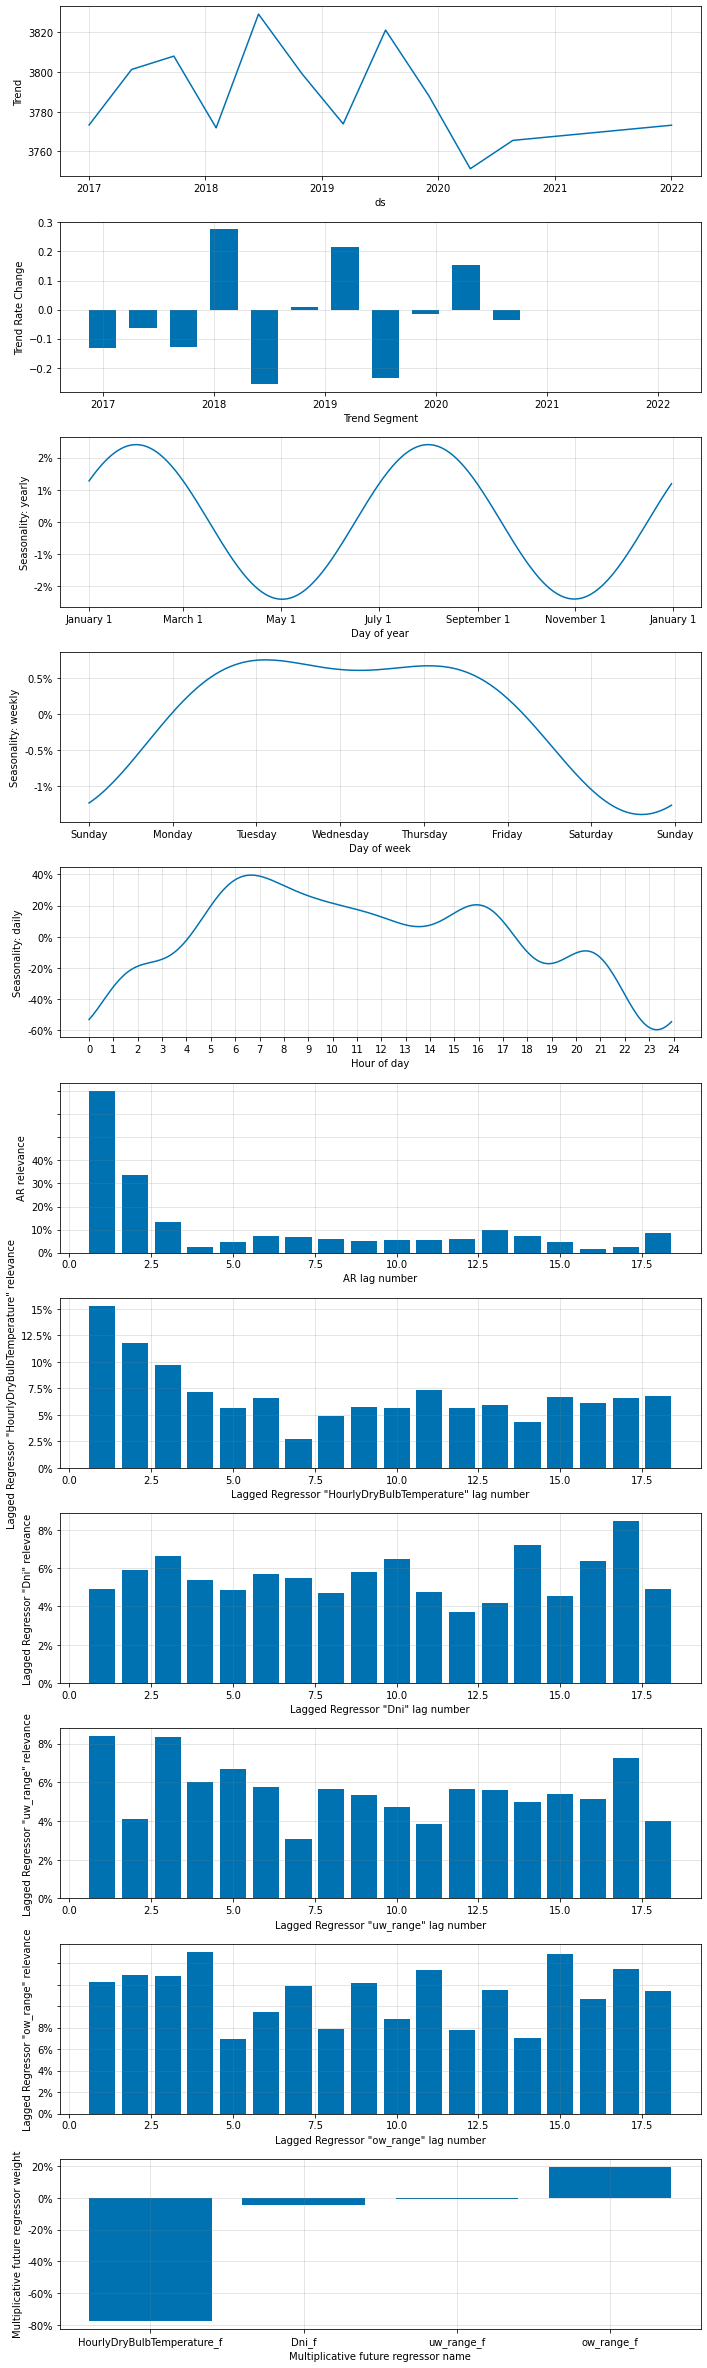

In [23]:


feature_columns = ['HourlyDryBulbTemperature', 'Dni']
additional_columns = ['uw_range', 'ow_range']


REG_PARAM=0.1
config = {'n_lags':18,
          'n_forecasts': 18,
          'yearly_seasonality':True, 
          'weekly_seasonality':True, 
          'daily_seasonality':True,
          'seasonality_mode':"multiplicative",
          'newer_samples_weight' :2.5,
          'num_hidden_layers' : 1,
          'seasonality_reg' : 0.1,
          'epochs' : 25, 
          'trainer_config': trainer_config}


m_h_w_f_m = NeuralProphet(**config)

m_h_w_f_m = m_h_w_f_m.add_events(['holiday'], mode='multiplicative', regularization = REG_PARAM)
m_h_w_f_m = m_h_w_f_m.add_lagged_regressor(names = feature_columns+ additional_columns) 
for col in feature_columns+additional_columns:
  m_h_w_f_m = m_h_w_f_m.add_future_regressor(f'{col}_f', mode='multiplicative') 
m_h_w_f_m = m_h_w_f_m.highlight_nth_step_ahead_of_each_forecast(18)
name = f"sea_{m_h_w_f_m.config['daily_seasonality']}_reg_{m_h_w_f_m.config['seasonality_reg']}_indicator"


set_random_seed(2023)
train_w, val_w = get_cols(feature_columns)

test = train_w.set_index('ds')
train_w['uw_range'] = 0
train_w['ow_range'] = 0
train_w.loc[test.index.isin(test.between_time('04:00', '05:30').index),'uw_range'] = 1
train_w.loc[test.index.isin(test.between_time('06:15', '07:45').index),'ow_range'] = 1
train_w.loc[test.index.isin(test.between_time('16:30', '17:30').index),'ow_range'] = 1

test= val_w.set_index('ds')
val_w['uw_range'] = 0
val_w['ow_range'] = 0
val_w.loc[test.index.isin(test.between_time('04:00', '05:30').index),'uw_range'] = 1
val_w.loc[test.index.isin(test.between_time('06:15', '07:45').index),'ow_range'] = 1
val_w.loc[test.index.isin(test.between_time('16:30', '17:30').index),'ow_range'] = 1

for col in feature_columns+additional_columns:
  train_w[f'{col}_f']= train_w[col]
  val_w[f'{col}_f']= val_w[col]

train_w = m_h_w_f_m.create_df_with_events(train_w, df_holiday)
val_w = m_h_w_f_m.create_df_with_events(val_w, df_holiday)

m_h_w_f_m_metric = m_h_w_f_m.fit(train_w,
                          validation_df = val_w,
                          freq='5min')

forecast_h_w_f_m_raw = m_h_w_f_m.predict(val_w, raw = True)
forecast_h_w_f_m = m_h_w_f_m.predict(val_w)

m_h_w_f_m = m_h_w_f_m.highlight_nth_step_ahead_of_each_forecast()
param = m_h_w_f_m.plot_parameters(plotting_backend = 'default')
param.savefig(f'{MPLOT_DIR}/NP_{name}.png') 

forecast_h_w_f_m['error17'] = forecast_h_w_f_m['yhat17'] - forecast_h_w_f_m['y']
forecast_h_w_f_m_raw.to_csv(f'{FORECAST_DIR}/neuralprophet_{name}_raw.csv')
forecast_h_w_f_m.to_csv(f'{FORECAST_DIR}/neuralprophet_{name}_f.csv')
save(m_h_w_f_m, f"{MODEL_DIR}/neuralphrophet_{name}_f.np")
print(RRMSE(np.array(forecast_h_w_f_m[34:-18]['y']), np.array(forecast_h_w_f_m[34:-18]['yhat17'])))

<Axes: xlabel='ds'>

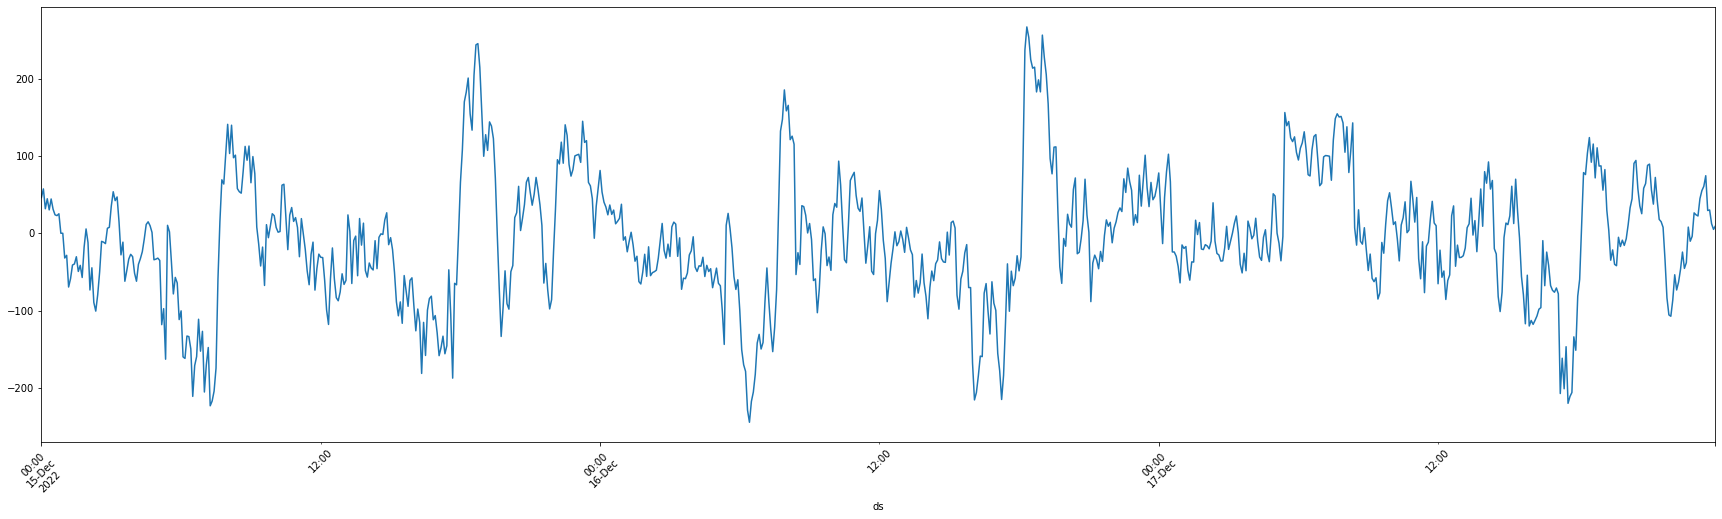

In [27]:
forecast1 = forecast_h_w_f_m.set_index('ds')
forecast1.iloc[-24*12*17:-24*12*14,]['error17'].plot(figsize=(30,8), rot = 45)

<Axes: xlabel='ds'>

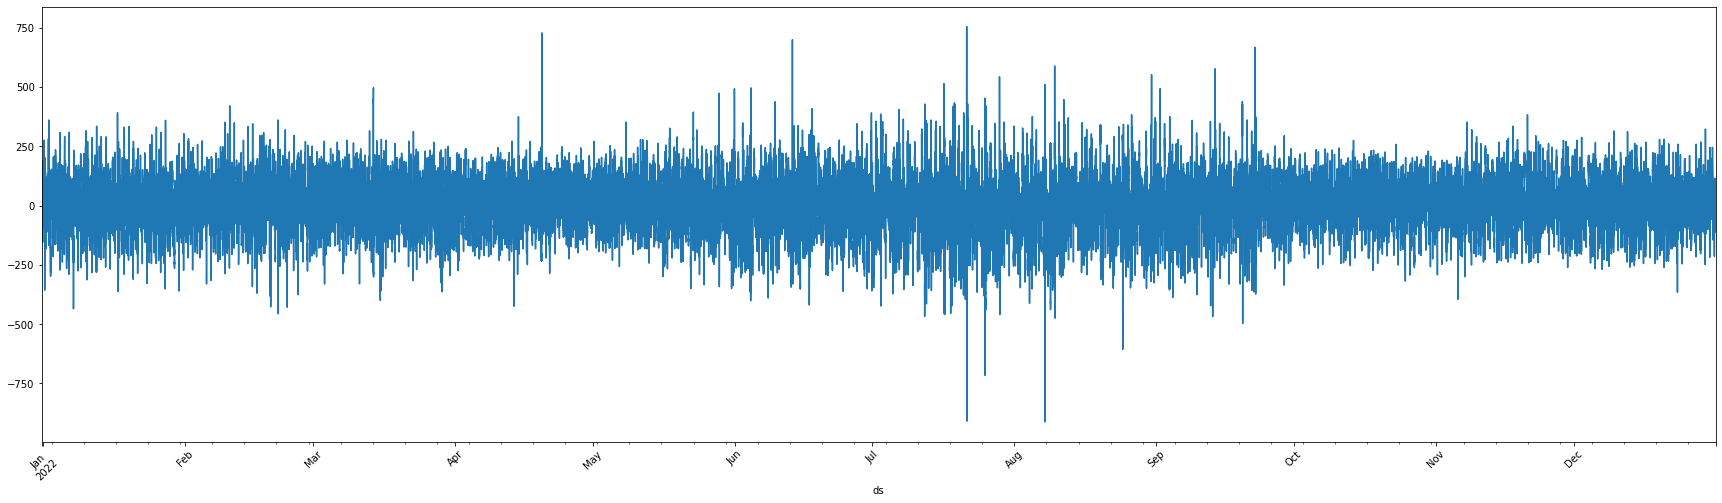

In [28]:
forecast1['error17'].plot(figsize=(30,8), rot = 45)

In [30]:
min(forecast1['error17'].dropna())

-911.6776015625001

In [31]:
max(forecast1['error17'].dropna())

754.7869374999991